In [35]:
import pathlib
import datetime
import json
from collections import defaultdict
import pathlib

from readability import Readability
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
import ollama

CWD = pathlib.Path("").parent

In [26]:
# Load the dataset
dfs = pd.read_excel('./data/accumulative_metrics.xlsx', sheet_name=None)

In [27]:
# Preprocessing
assignment_names = ['Suffrage', 'Ants', 'Clouds', 'Waterclocks', 'Lizards', 'Tastes', 'Lodgepoles']
all_dfs = []

# Keep only the top features
with open('handpicked_top_features.json', 'r') as f:
    top_features = json.load(f)['features']

print([x for x in top_features])

for assignment_name in assignment_names:
    df = dfs[assignment_name]
    assignment_top_features = [f"{assignment_name}_{x}" for x in top_features]
    df = df[['id', f"{assignment_name}_score"] + assignment_top_features]
    df['assignment'] = assignment_name
    all_dfs.append(df)

# Add student attributes and join via 'id
student_attributes = pd.read_excel('./data/student_attributes.xlsx')
all_dfs = [df.merge(student_attributes, on='id', how='left') for df in all_dfs]

# Show 'Suffrage' df
print(all_dfs[0].head())

['total_forward_wpm_mean', 'coldread_coverage_word_%', 'coldread_dwell_time_pdf', 'qa_fix_dispersion_mean', 'qa_dwell_time_quiz']
    id  Suffrage_score  Suffrage_total_forward_wpm_mean  \
0  103        0.666667                           287.93   
1  104        0.444444                           256.99   
2  105        0.444444                           288.92   
3  108        0.444444                           229.73   
4  109        0.388889                           271.11   

   Suffrage_coldread_coverage_word_%  Suffrage_coldread_dwell_time_pdf  \
0                              33.72                            135.08   
1                              24.46                            183.95   
2                              18.38                             95.58   
3                              12.45                             83.68   
4                              16.06                             58.47   

   Suffrage_qa_fix_dispersion_mean  Suffrage_qa_dwell_time_quiz assign

/var/folders/wg/5f3q13d11215w5syssg034n80000gn/T/ipykernel_51324/2806985845.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['assignment'] = assignment_name
/var/folders/wg/5f3q13d11215w5syssg034n80000gn/T/ipykernel_51324/2806985845.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['assignment'] = assignment_name
/var/folders/wg/5f3q13d11215w5syssg034n80000gn/T/ipykernel_51324/2806985845.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

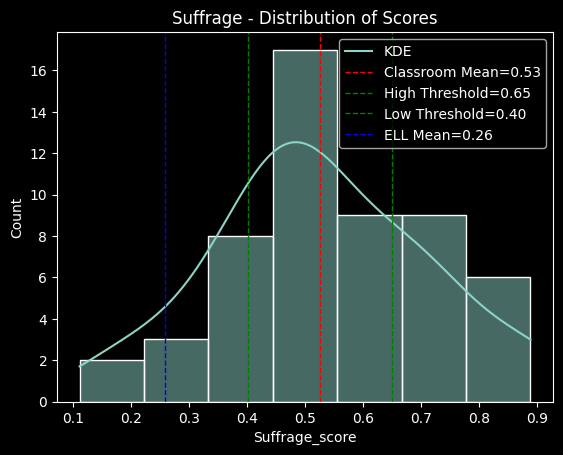

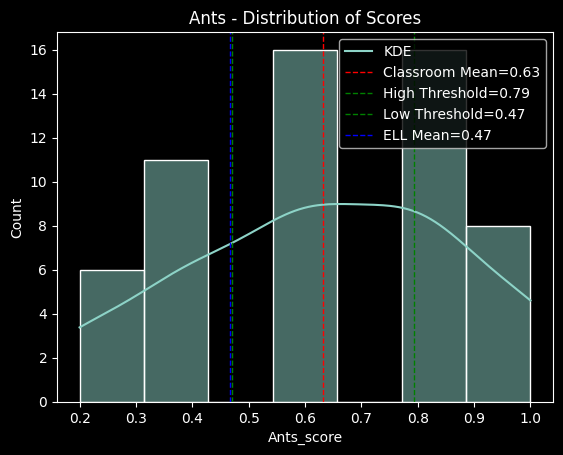

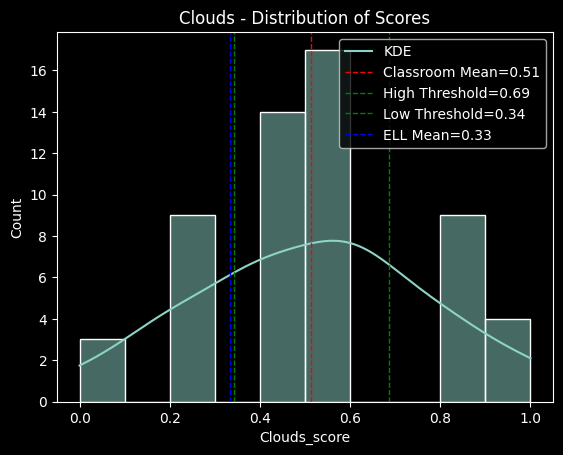

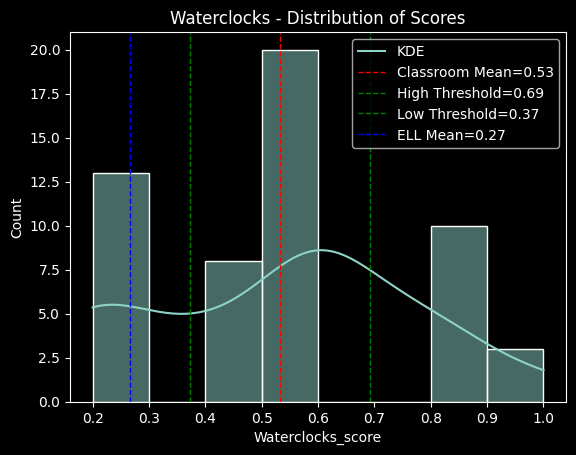

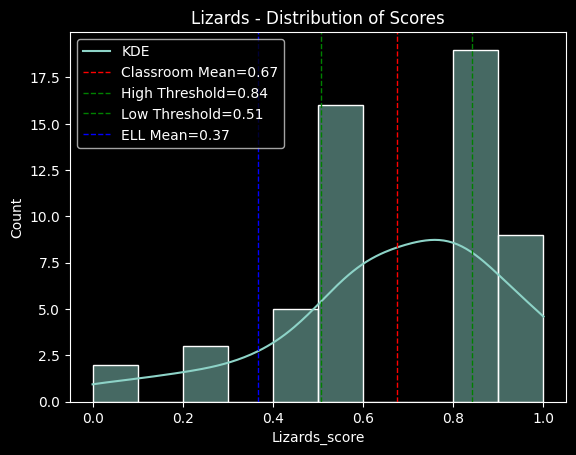

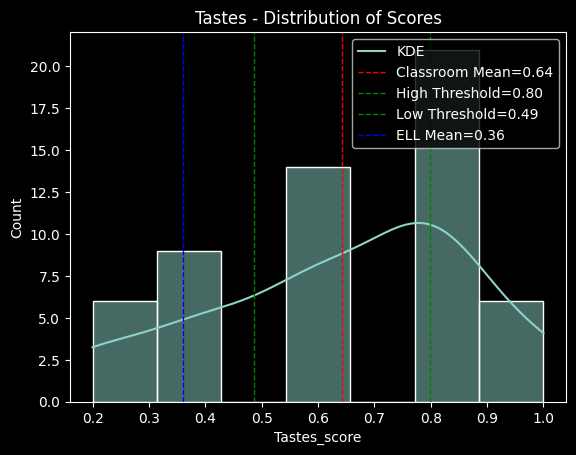

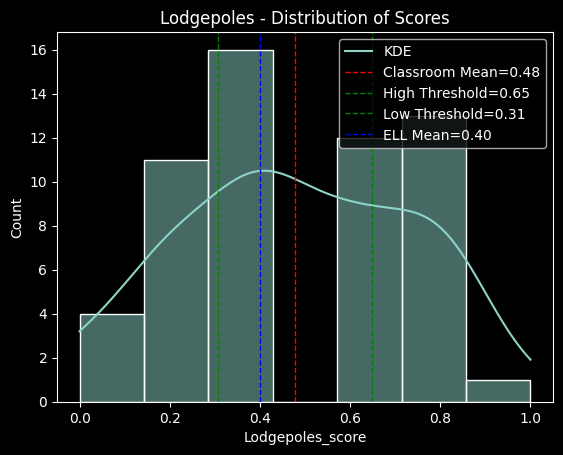

In [28]:
# For each assignment, perform the same processing
for assignment_name, df in zip(assignment_names, all_dfs):

    # Generate groups based on the mean and std thresholds and plot the distribution of the group scores
    mean = df[f'{assignment_name}_score'].mean()
    std = df[f'{assignment_name}_score'].std()
    high_threshold = mean + std/1.5
    low_threshold = mean - std/1.5

    # Create a new figure for each assignment
    plt.figure()

    # Plot the distribution of the scores
    sns.histplot(df[f'{assignment_name}_score'], kde=True)

    # Add the mean and median
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label='Classroom Mean')

    # Add the thresholds
    plt.axvline(high_threshold, color='g', linestyle='dashed', linewidth=1)
    plt.axvline(low_threshold, color='g', linestyle='dashed', linewidth=1)

    # Plot the mean score for special groups (Disability and ELL)
    ell_mean = df[df['ELL'] == 'Yes'][f'{assignment_name}_score'].mean()
    plt.axvline(ell_mean, color='b', linestyle='dashed', linewidth=1, label='ELL Mean')

    # Add legend with the values
    plt.legend({
        f"KDE": None,
        f'Classroom Mean={mean:.2f}': mean,
        f'High Threshold={high_threshold:.2f}': high_threshold,
        f'Low Threshold={low_threshold:.2f}': low_threshold,
        f'ELL Mean={ell_mean:.2f}': ell_mean
    })
    plt.title(f'{assignment_name} - Distribution of Scores')

    # Show the plot
    plt.show()

In [29]:
for assignment_name, df in zip(assignment_names, all_dfs):
    df['group'] = ''
    df.loc[df[f'{assignment_name}_score'] > high_threshold, 'group'] = 'H' # High Performers
    df.loc[(df[f'{assignment_name}_score'] <= high_threshold) & (df[f'{assignment_name}_score'] > low_threshold), 'group'] = 'M' # Medium Performers
    df.loc[(df[f'{assignment_name}_score'] <= low_threshold), 'group'] = 'L' # Low Performers
    df.head(10)

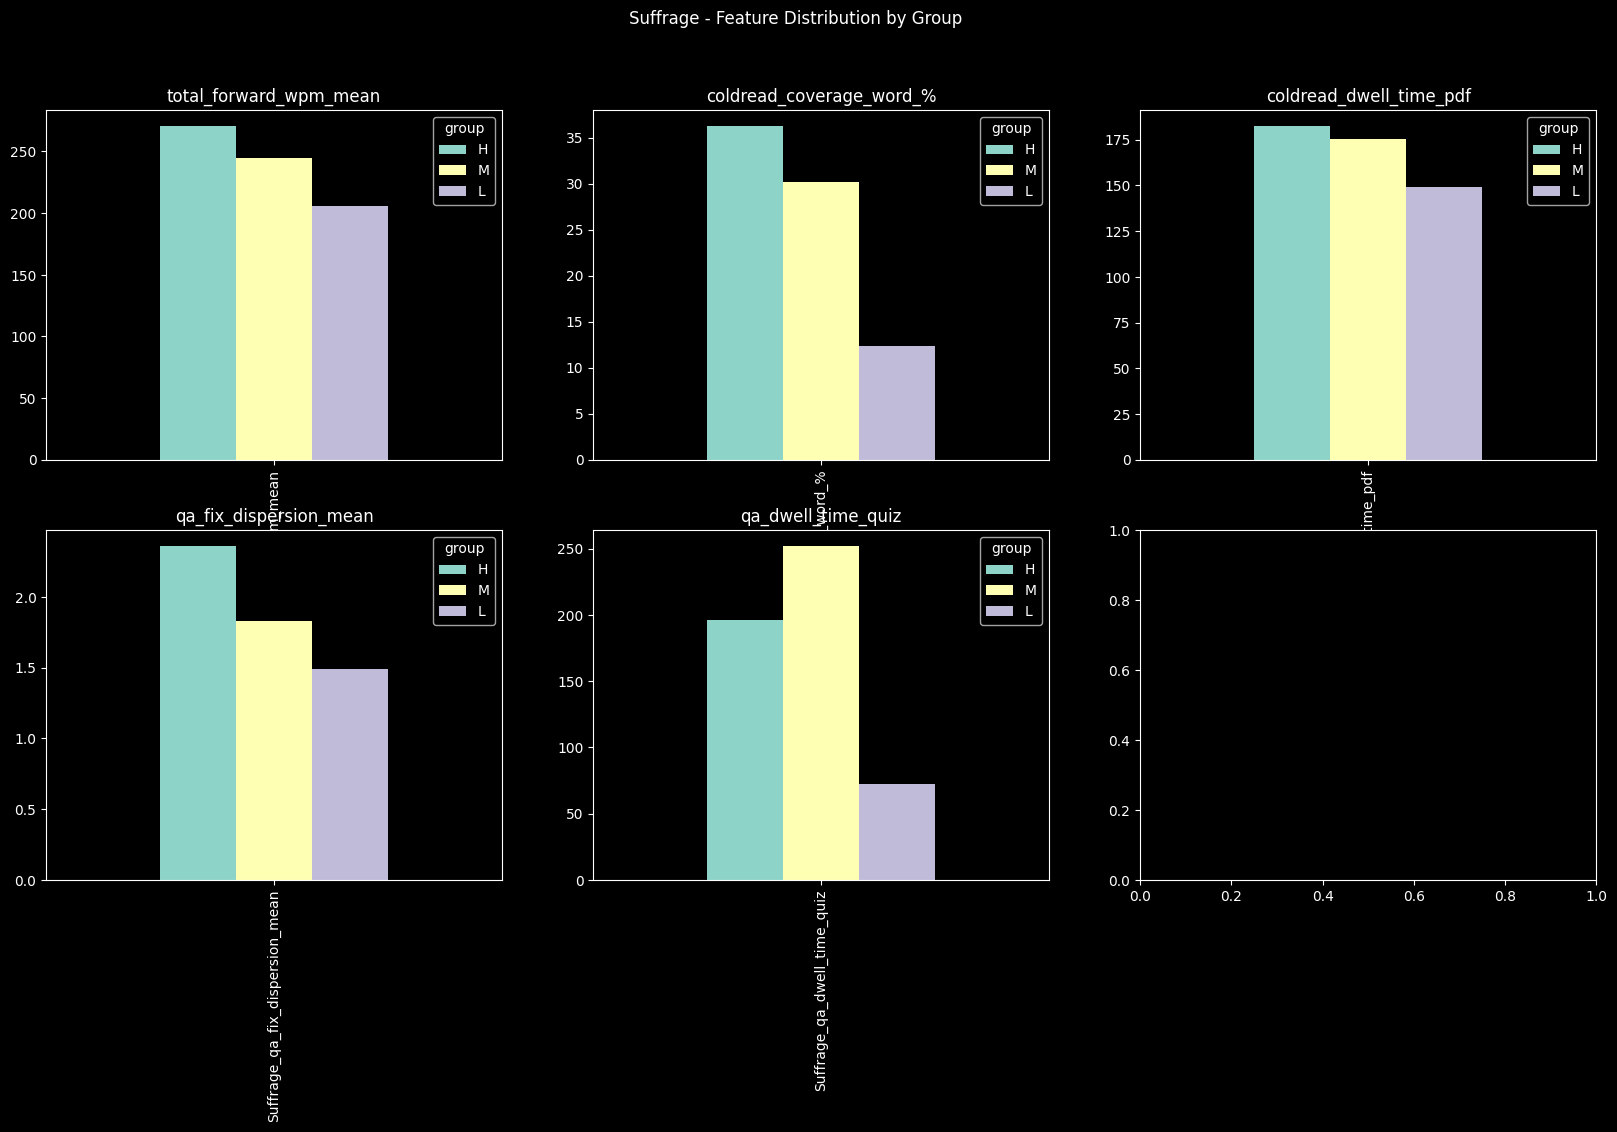

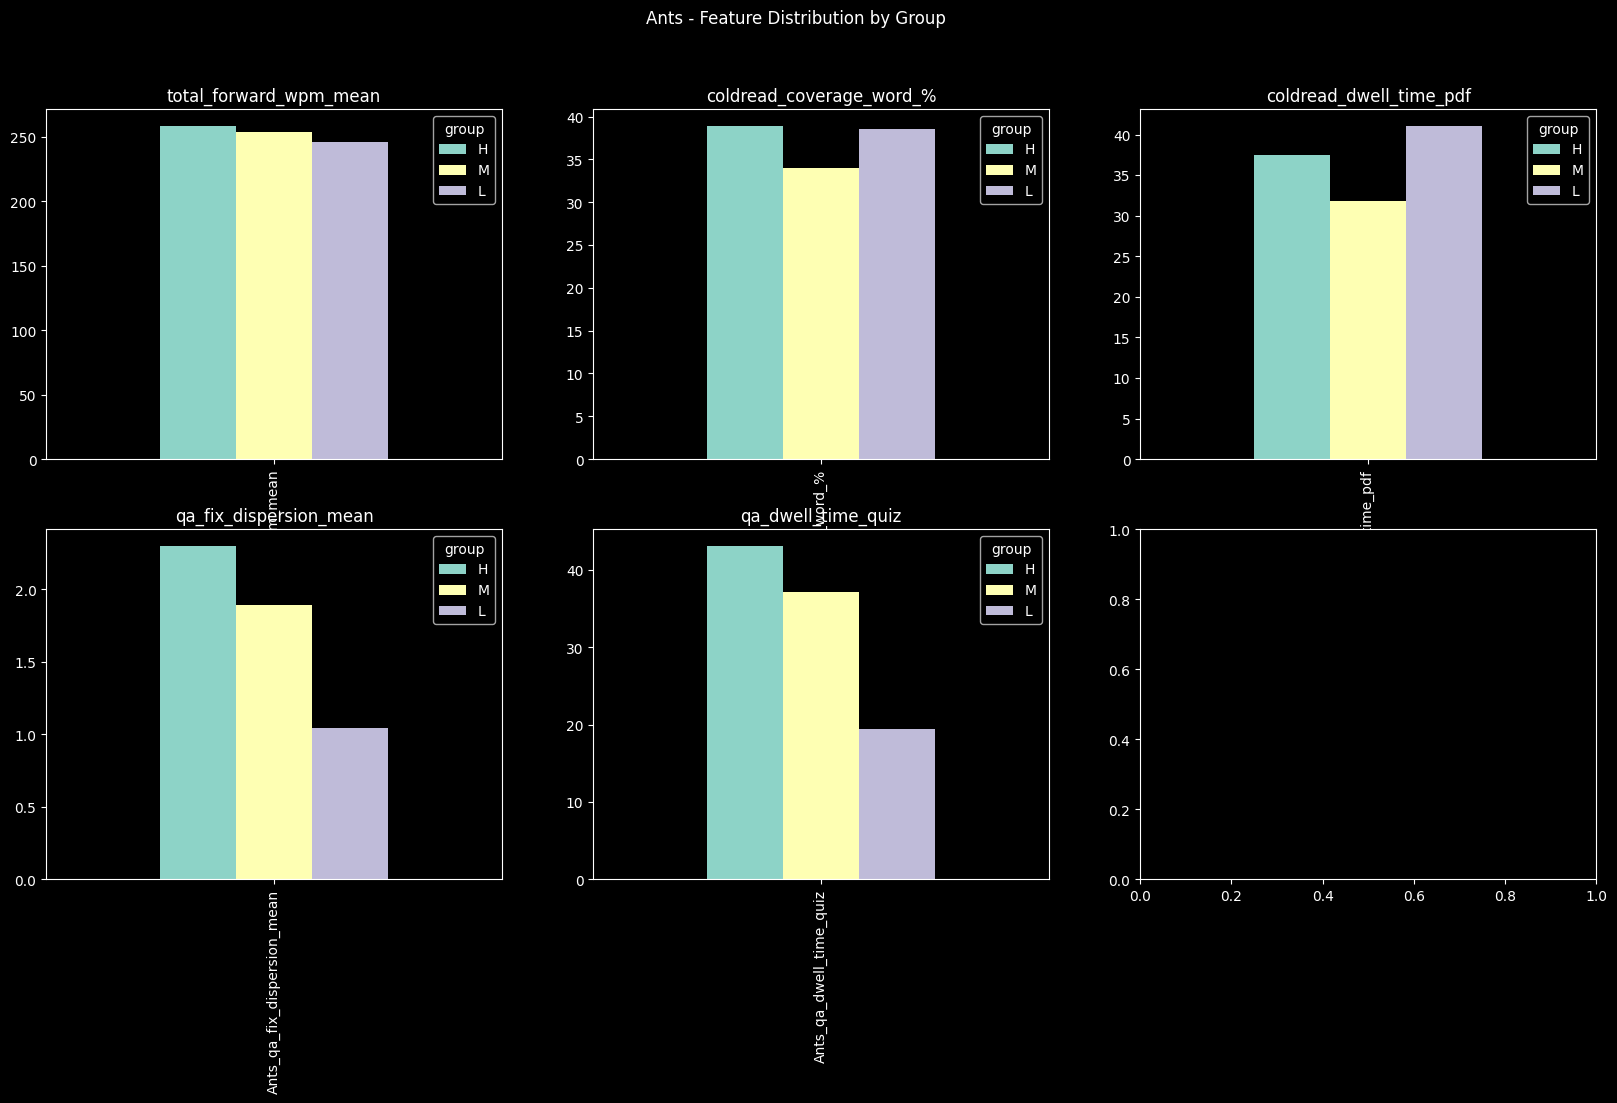

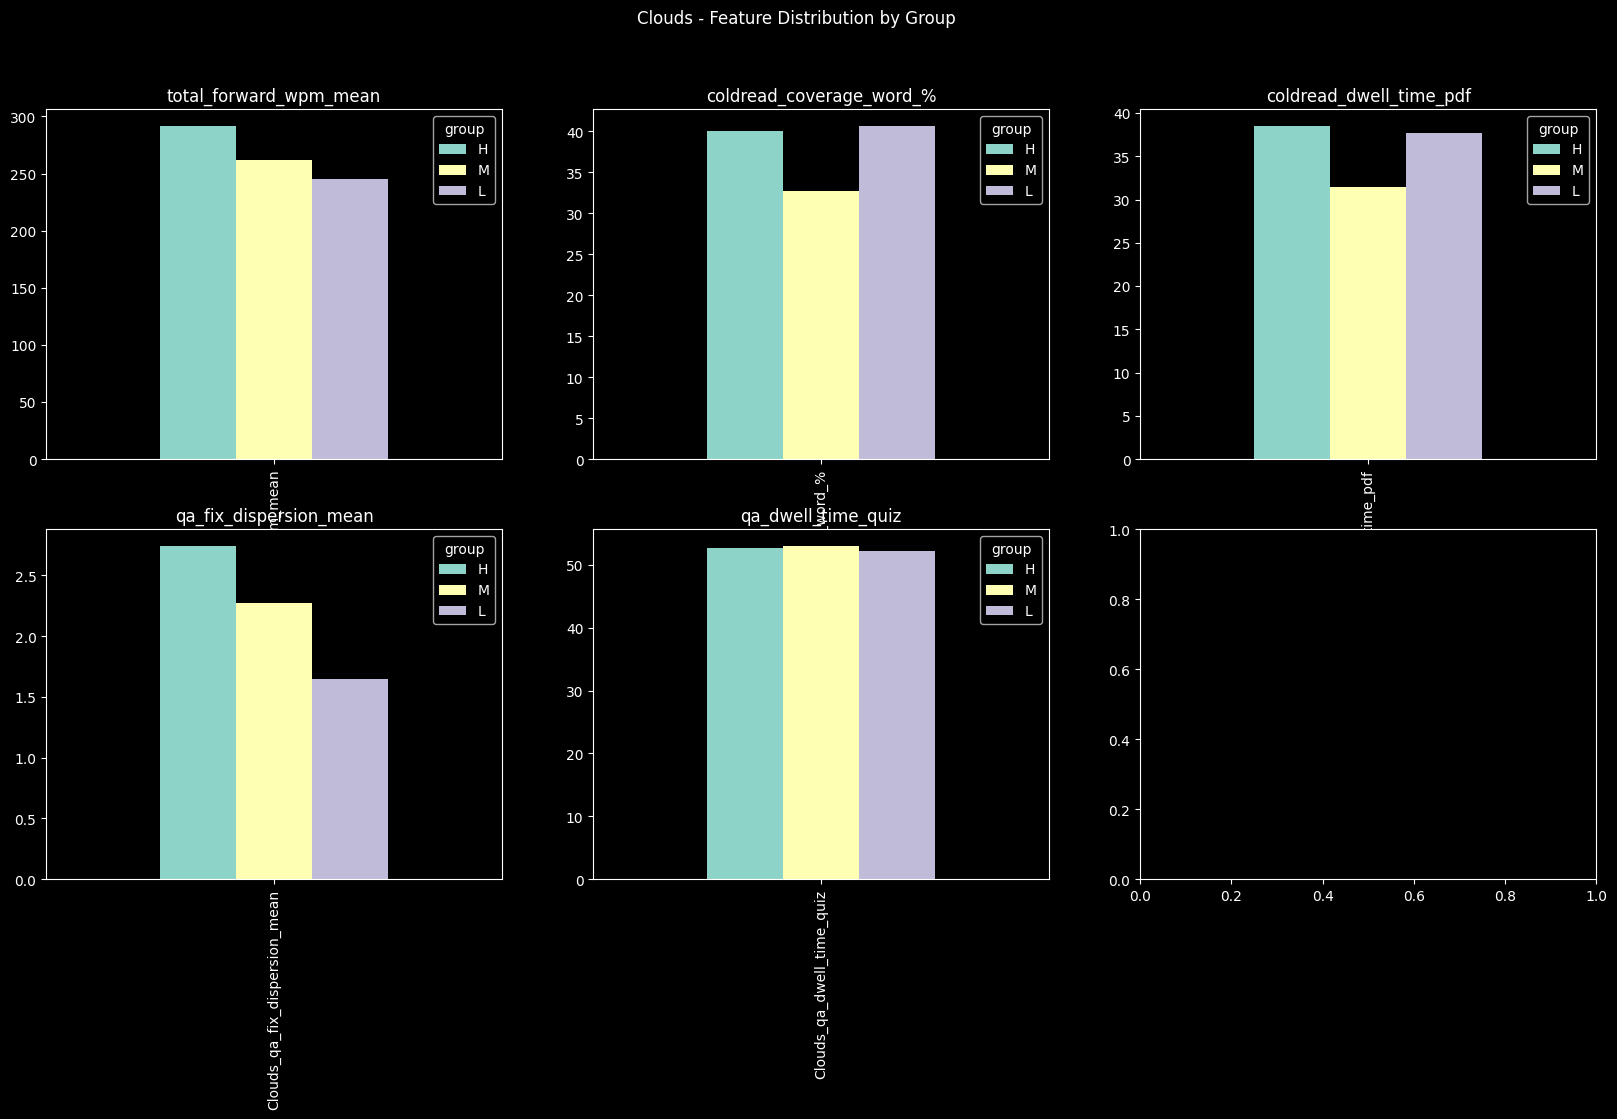

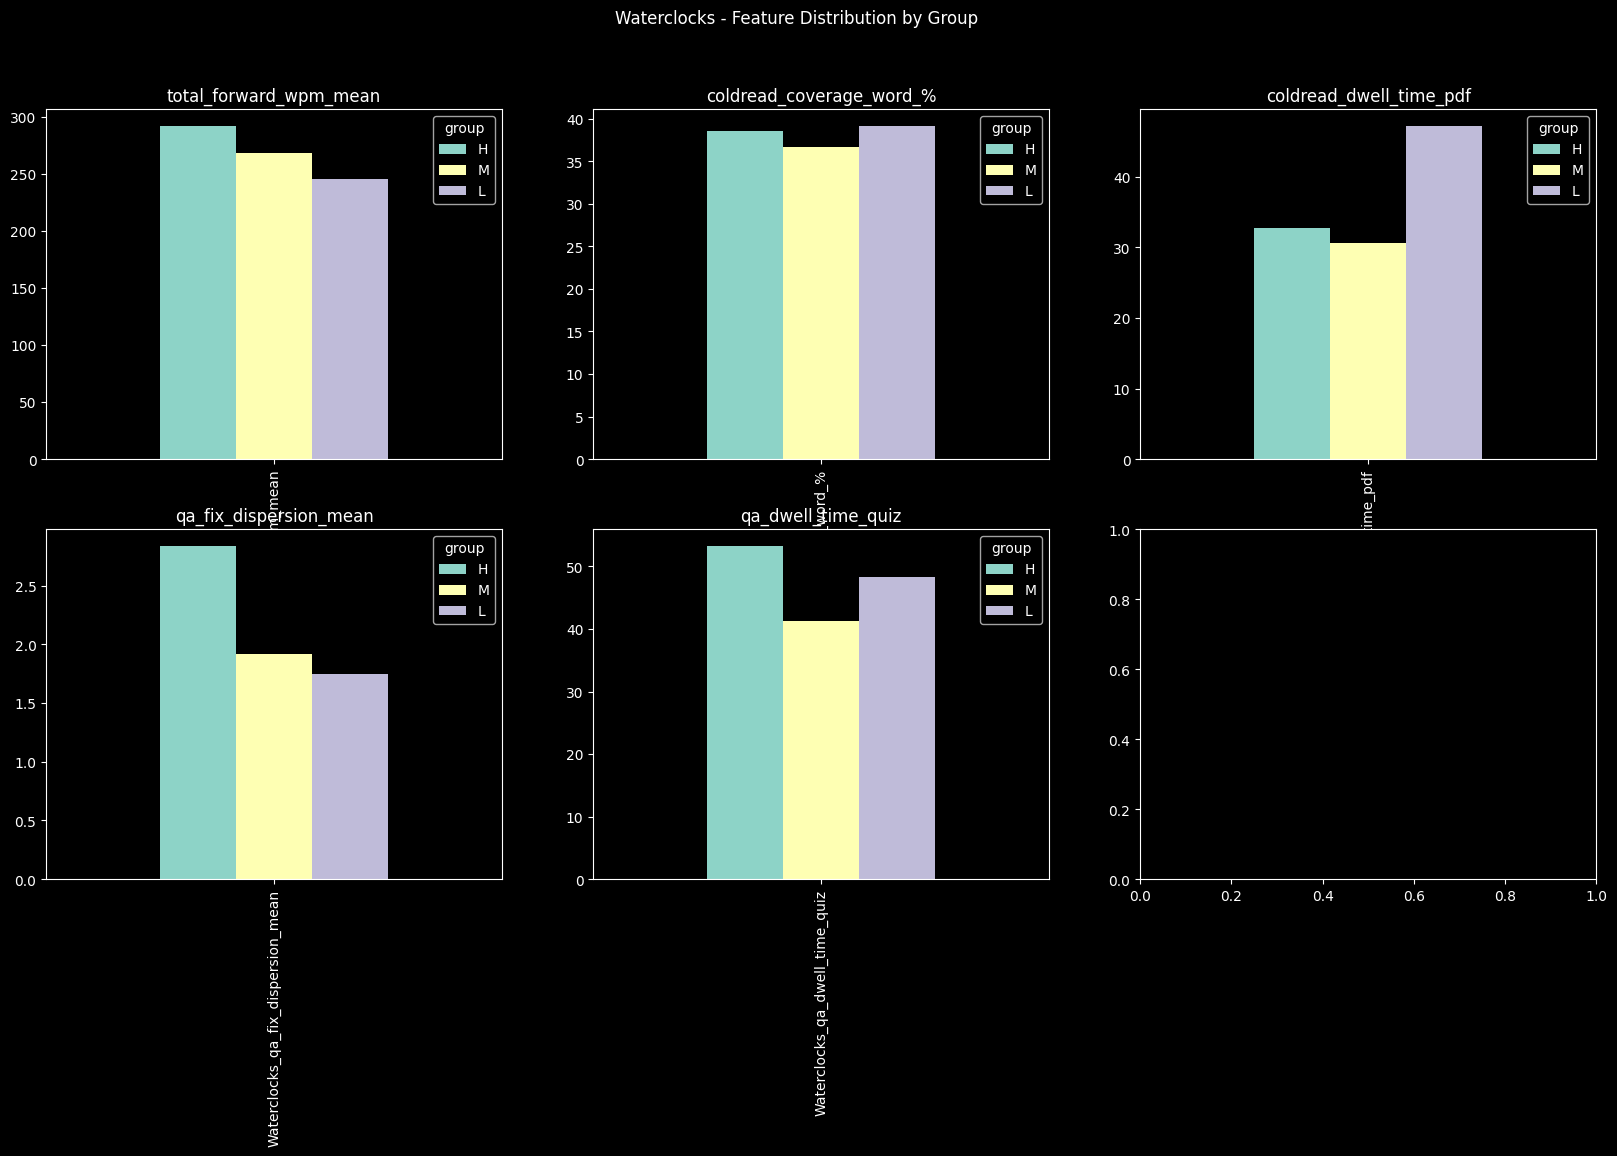

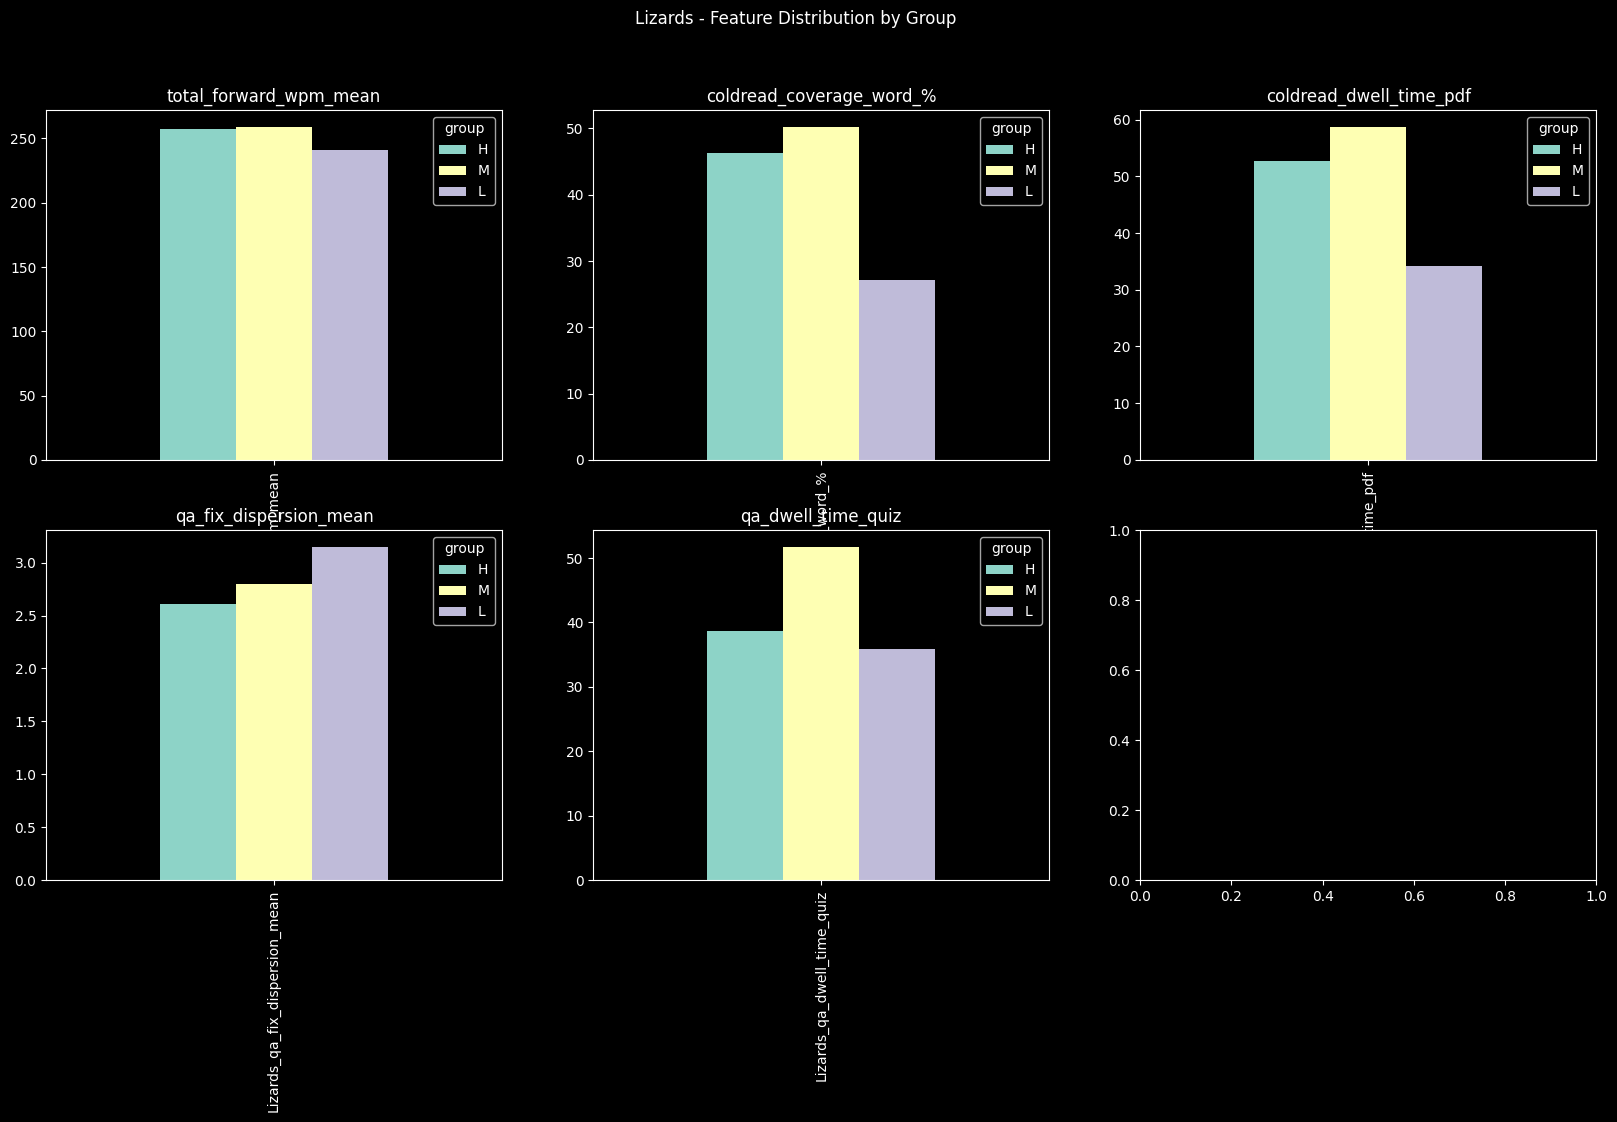

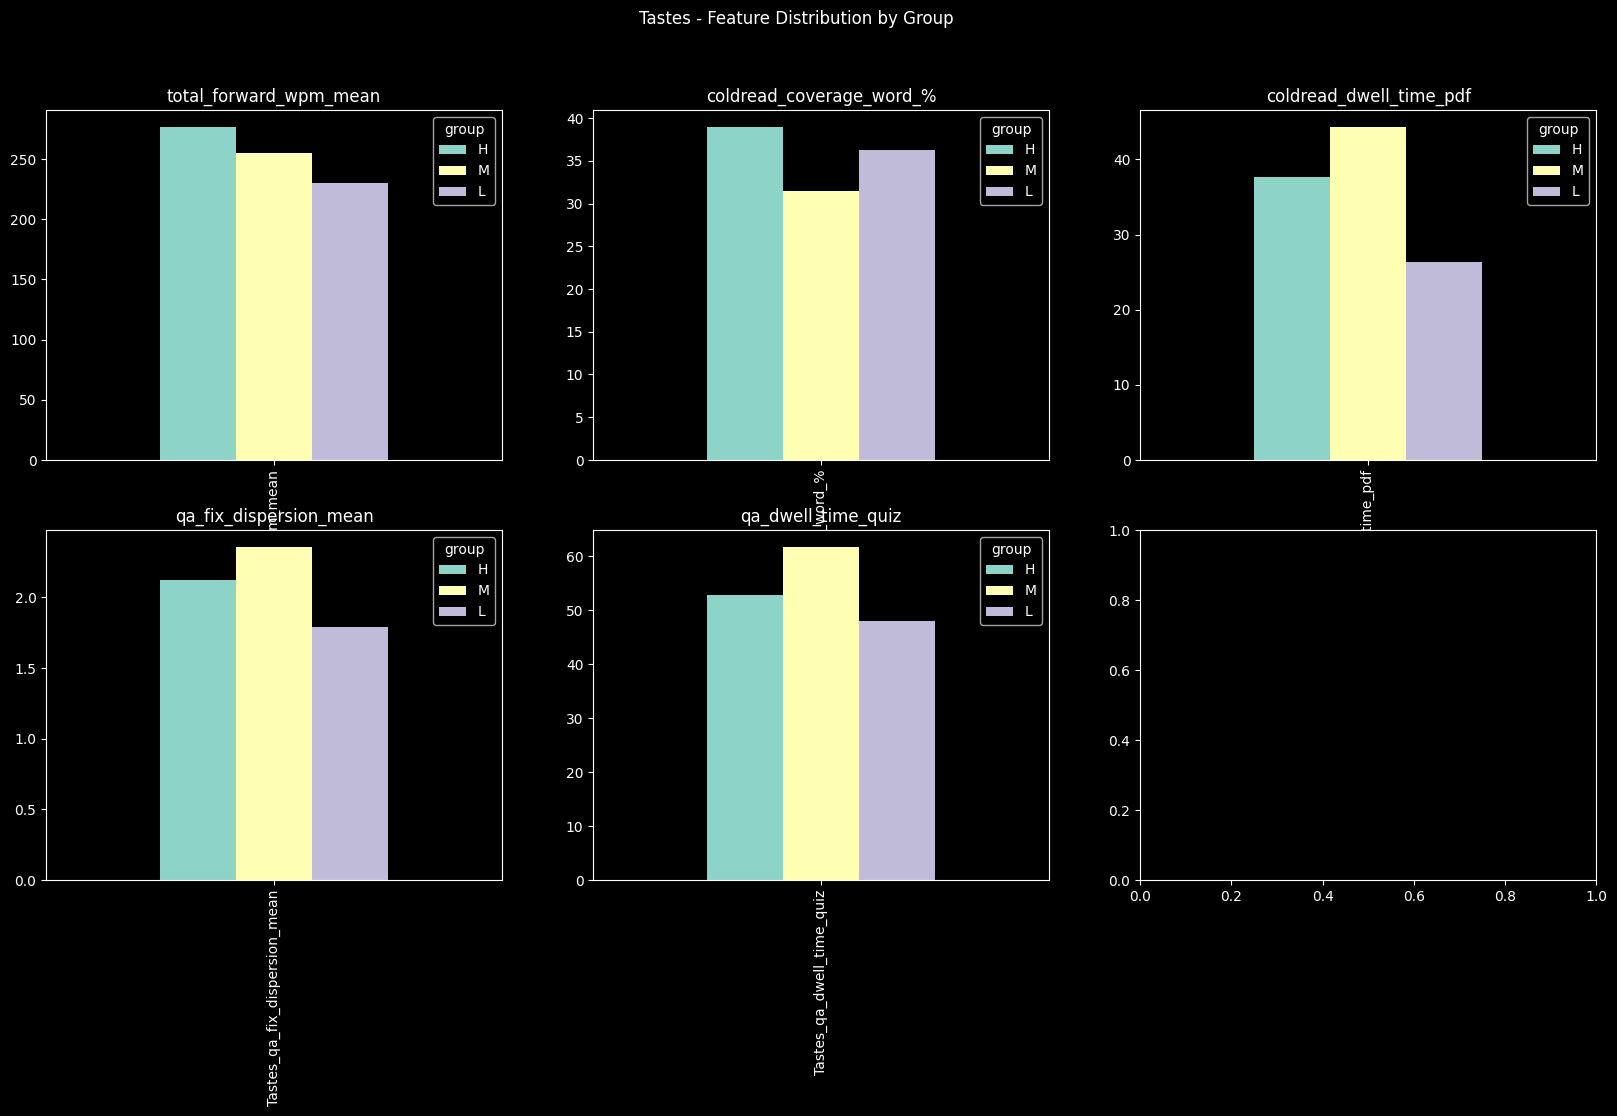

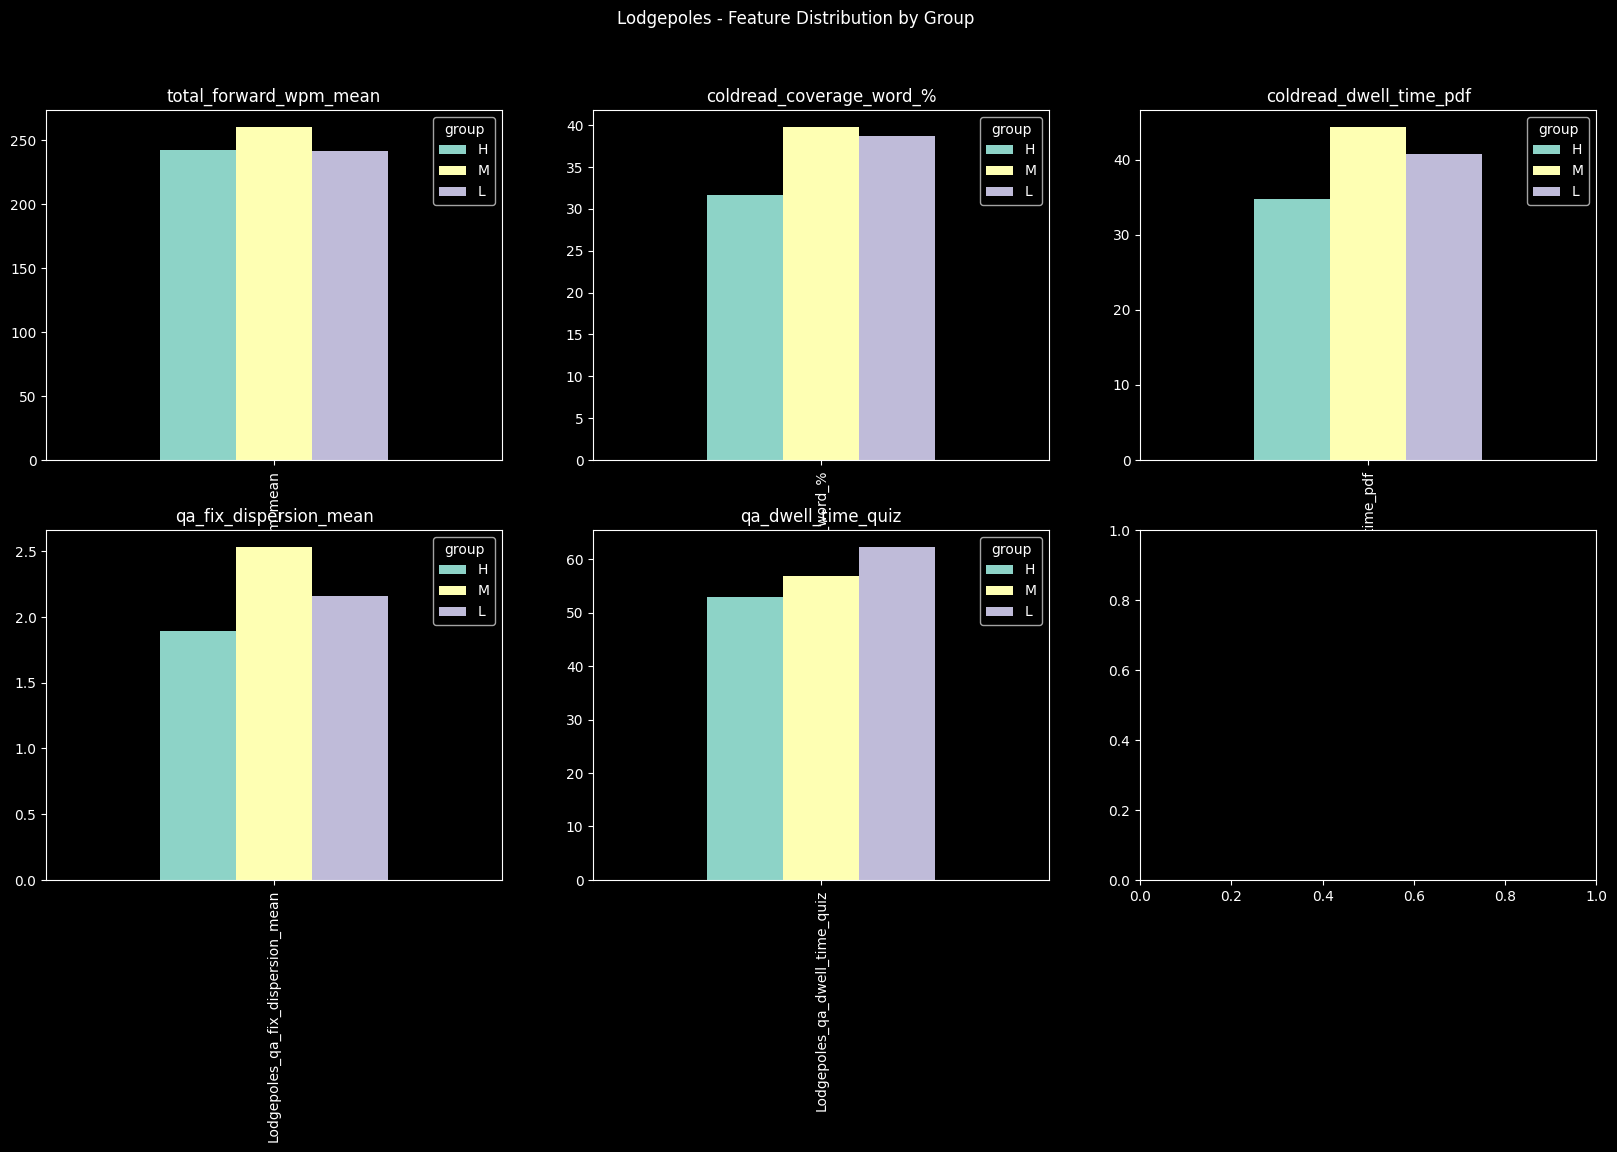

In [30]:
for assignment_name, df in zip(assignment_names, all_dfs):

    # Compute the mean and std of each feature by group
    numeric_df = df.select_dtypes(include='number')
    all_grouped = numeric_df.groupby(df['group']).mean()
    num_of_rows = len(top_features) // 3 + 1

    # Make into subplots and plot each feature separately
    fig, axs = plt.subplots(num_of_rows, 3, figsize=(20, 10))
    fig.suptitle(f'{assignment_name} - Feature Distribution by Group')
    for i, feature in enumerate(top_features):
        feature_df = all_grouped[[f"{assignment_name}_{feature}"]]
        feature_df.loc[['H', 'M', 'L']].T.plot(kind='bar', ax=axs[i//3, i%3], title=feature)

In [31]:
# Load the txts data for each passage
TXT_DIR = "./data/pdfs/txt"
texts = {}
for assignment_name in assignment_names:
    txt = open(f"{TXT_DIR}/{assignment_name}.txt", "r").read()
    texts[assignment_name] = txt

# Load the summaries of the passages
SUMMARY_DIR = "./data/pdfs/summaries"
summaries = {}
for assignment_name in assignment_names:
    txt = open(f"{SUMMARY_DIR}/{assignment_name}.txt", "r").read()
    summaries[assignment_name] = txt

In [36]:
# Define the prompt for the clasroom-wide report of an assignment
def compute_group_metrics(df, assignment_name):
  metrics = {
    'count': len(df),
    'score_mean': df[f"{assignment_name}_score"].mean(),
    'score_std': df[f"{assignment_name}_score"].std(),
    **{f"{assignment_name}_{feature}": df[f"{assignment_name}_{feature}"].mean() for feature in top_features}
  }

  # Round metrics to 2 decimal places
  metrics = {k: round(v, 2) for k, v in metrics.items()}
  return metrics

def generate_prompt(assignment_name, df, text, summary):

    # Analyze the readability of text
    r = Readability(text)

    # Compute group metrics for H, M, and L students
    group_metrics = {}
    for name, group in df.groupby('group'):
        group_metrics[name] = compute_group_metrics(group, assignment_name)

    # Compute group metrics for ELL students
    ELL_df = df[df['ELL'] == 'Yes']
    ELL_metrics = compute_group_metrics(ELL_df, assignment_name)
    
    prompt = {
      "role": "AI Educational Analyst",
      "task": "Generate a classroom-wide report for a reading assignment based on provided student performance and eye-tracking data. The report should analyze trends, justify key findings, and offer actionable recommendations.",
      "context": {
        "assignment": {
          "title": assignment_name,
          "flesch_kincaid_grade_level": r.flesch_kincaid().grade_level,
          "flesch_kincaid_score": r.flesch_kincaid().score,
          "word_count": len(text.split()),
          "summary": summary
        },
        "class_summary": {
          "grade_level": "5th Grade",
          "total_students": len(df),
          "high_performers": group_metrics['H'],
          "mid_performers": group_metrics['M'],
          "low_performers": group_metrics['L']
        },
        "special_groups": {
          "ELL_students": ELL_metrics
        }
      },
      "analysis_requirements": {
        "performance_summary": "Provide a structured breakdown of high, mid, and low performers, relating their performance to reading difficulty and content knowledge.",
        "eye_tracking_analysis": f"Analyze eye-tracking behaviors and justify how they correlate with comprehension. Provide a clear justification for how features like [{top_features}] influence reading efficiency.",
        "special_group_analysis": "Examine trends among ELL students, compare their performance to the class average, and justify why these trends exist.",
      },
      "output_format": {
        "title": f"Classroom-Wide Report: {assignment_name}",
        "instructions": "Generate a high-overview report that includes a summary of key findings, actionable recommendations, and a detailed analysis of student performance.",
        "format": "Markdown"
      }
    }
    return prompt

prompt_res_table = defaultdict(list)
for assignment_name, df in zip(assignment_names, all_dfs):
    text = texts[assignment_name]
    summary = summaries[assignment_name]
    prompt = generate_prompt(assignment_name, df, text, summary)

    res = ollama.chat(
        model="llama3",
        messages=[
            {
                "role": "user",
                "content": json.dumps(prompt)
            }
        ]
    )
    
    content = res['message']['content']
    # Write into a markdown file
    with open(f"./data/reports/{assignment_name}.md", "w") as f:
        f.write(content)

    # Store the results in a table
    prompt_res_table['assignment'].append(assignment_name)
    prompt_res_table['prompt'].append(prompt)
    prompt_res_table['response'].append(content)

    break

# Save the results into a table
timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
prompt_res_df = pd.DataFrame(prompt_res_table)
prompt_res_df.to_excel(CWD / 'data' / 'prompt_responses' / f"res_{timestamp}.xlsx", index=False)